# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [29]:
# Change here using YOUR first and last names
fn1 = "ahmed"
ln1 = "eddahbi"
fn2 = "thihaiyen"
ln2 = "vu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_eddahbi_ahmed_and_vu_thihaiyen.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

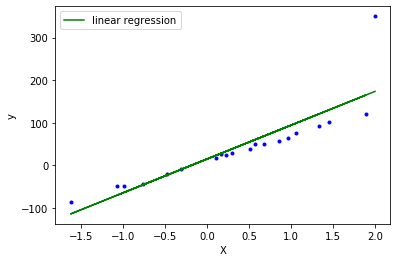

In [4]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state = 24,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

We can see from the figure above that the square loss ($\|\cdot\|^2$) is not robust to outliers. The regressor tend to point out to the outlier making the model incorrect. This is because squared distance tends to be very big for outlier points (unlike absolute distance), thus it has to move the line towards the outlier in order to minimise the loss. To solve this problem, we can either:
* Use the absolute loss instead of squared loss, so that the outlier is penalized equally as other points.
* Add a regularization term so that the model generalizes better and hence reduce overfitting behaviors like above.

## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [5]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

[]

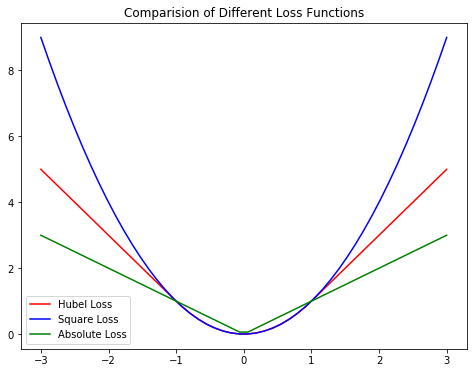

In [6]:
### TODO
plt.figure(figsize=(8,6))
x_lin = np.linspace(-3,3)

plt.plot(x_lin, huber(x_lin, epsilon=1), color='r', label='Hubel Loss')
plt.plot(x_lin, x_lin**2, color ='b', label='Square Loss')
plt.plot(x_lin, np.abs(x_lin), color='g', label ='Absolute Loss')

plt.legend()
plt.title('Comparision of Different Loss Functions')
plt.plot()
### END TODO

We see that the Hubel function is continuous, it coincides with the squared function in the range $[-\epsilon, \epsilon]$. Then it takes the form of the absolute function and lies inside the squared and absolute functions.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

#### Convexity of $H$

We compute the first derivative of $H_\epsilon (x)$:
$$H'_\epsilon (x) = \left\{
	\begin{aligned}
	2x & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon & \quad x > \epsilon \\
    - 2 \epsilon  & \quad x < -\epsilon
	\end{aligned}
    \right.$$
We see that $H'_\epsilon (x)$ is a continuous, non decreasing function, hence $H_\epsilon (x)$ is convex. 

Indeed, for all $x,y\in\mathbb{R}:$
$$H_\epsilon (x)-H_\epsilon (y) = H'_\epsilon (z)(x-y),$$
where $z$ lies between $x$ and $y$. 

If $x> y$, then $z >y$ and $H'_\epsilon (z)(x-y) > H'_\epsilon (y)(x-y)$. If $y> x$, then $z < y$ and $H'_\epsilon (z)(x-y) > H'_\epsilon (y)(x-y)$. Thus we always have 
$$H_\epsilon (x)-H_\epsilon (y) \geq H'_\epsilon (y)(x-y),$$
which implies that $H_\epsilon (x)$ is a convex function.

#### Smoothness of $H$

We'll now prove that:
$$|H'_\epsilon (x)-H'_\epsilon (y)| \leq 2|x-y|, \quad \forall x,y\in\mathbb{R}. $$
Then we can conclude that $H_\epsilon (x)$ is $2$-smooth.

We divide $\mathbb{R}$ into three intervals $(-\infty,-\epsilon); [-\epsilon,\epsilon]$ and $(\epsilon,+ \infty)$. WLOG, we can suppose that $x>y$. We consider the following cases:
* If $x,y$ both lie in $(-\infty,-\epsilon)$ or $(\epsilon,+ \infty)$, then $|H'_\epsilon (x)-H'_\epsilon (y)| = 0 \leq 2|x-y|$.
* If $x,y$ both lie in $[-\epsilon,\epsilon]$, then $|H'_\epsilon (x)-H'_\epsilon (y)| = 2|x-y|$.
* If $y\in (-\infty,-\epsilon)$ and $x \geq -\epsilon$, we then have $H'_\epsilon (y) = -2\epsilon > 2y$ and $H'_\epsilon (x) \leq 2x$. Thus $$|H'_\epsilon (x)-H'_\epsilon (y)| = H'_\epsilon (x)-H'_\epsilon (y) < 2x - 2y = 2|x-y|.$$
* If $y\in [-\epsilon,\epsilon]$ and $x \in (\epsilon,+ \infty)$, then $H'_\epsilon (y) = 2y$ and $H'_\epsilon (x) < 2x$. Thus 
$$|H'_\epsilon (x)-H'_\epsilon (y)| = H'_\epsilon (x)-H'_\epsilon (y) < 2x - 2y = 2|x-y|.$$

This concludes that $H_\epsilon (x)$ is $2$-smooth.

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

In [7]:
### TODO
def grad_huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = 2*x[mask]
    z[~mask] = 2 * epsilon *np.sign(x[~mask])
    return z

# Assess the result with check_grad
from scipy.optimize import check_grad
x_lin = np.linspace(-2*epsilon,2*epsilon,5)
for x0 in x_lin:
    print("Check_grad value for Huber Function (epsilon =",epsilon,") at",x0,":",
          check_grad(huber,grad_huber,np.array([x0])))

### END TODO

Check_grad value for Huber Function (epsilon = 1.0 ) at -2.0 : 0.0
Check_grad value for Huber Function (epsilon = 1.0 ) at -1.0 : 1.4901161193847656e-08
Check_grad value for Huber Function (epsilon = 1.0 ) at 0.0 : 1.4901161193847656e-08
Check_grad value for Huber Function (epsilon = 1.0 ) at 1.0 : 0.0
Check_grad value for Huber Function (epsilon = 1.0 ) at 2.0 : 0.0


We see that the check_grad values are indeed nearly zeros.

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

As we have shown above, $H_\epsilon(x)$ is a continously differentiable, $2$-smooth and convex function. We'll consider the two different regularization methods.
#### $\ell_1$ regularization
We know that $\ell_1$ regularization makes the cost function not continously differentiable in some points, hence gradient-based methods (L-BFGS, GD, CD) can be problematic and do not give desired results. In contrast, the $\|\cdot\|_1$ norm is convex and *prox-friendly* (we have a direct explicit formula for the proximal function), thus proximal methods (PGD, PCD) are readily applicable in this case.
#### Squared $\ell_2$ regularization
We know that $\|\cdot\|^2_2$ is continously differentiable, thus we can use gradient-based methods (L-BFGS, GD, CD) in this case. As we can find a formula for the proximal function of $\|\cdot\|^2_2$ norm, we can also apply proximal methods (PGD, PCD) for this regularization.

<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

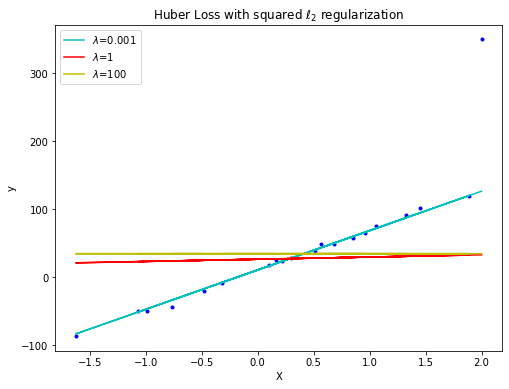

In [8]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)


def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    # TODO
    d = X.shape[1]
    init_params = np.zeros(d+1)
    
    def grad_huber_l2(params):
        w = params[1:]
        b = params[0]
        grad_huber_mat = grad_huber(y - np.dot(X, w) - b, epsilon=epsilon)
        grad_w = -np.mean(X * grad_huber_mat.reshape(-1,1), axis = 0) + 2*lbda*w
        grad_b = -np.mean(grad_huber_mat)
        return np.concatenate(([grad_b], grad_w))
    
    params, f_min, _ = fmin_l_bfgs_b(pobj_l2, init_params, grad_huber_l2)
    # END TODO
    return params

# TODO  (for visualization)
colors = ['c', 'r', 'y', 'm', 'g', 'k', 'w']
x = X[:, 0]

plt.figure(figsize=(8,6))
plt.plot(x, y, 'b.')

for i, lbd in enumerate([0.001, 1, 100]):
    lbfgs_res = huber_lbfgs_l2(X=X, y=y, lbda=lbd, epsilon=epsilon)
    b_hat, w_hat = lbfgs_res[0], lbfgs_res[1:]
    y_pred = w_hat * x + b_hat
    plt.plot(x, y_pred, 'g-', color=colors[i], label="$\lambda$="+str(lbd))
    
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.title("Huber Loss with squared $\ell_2$ regularization")
plt.show()
# END TODO

We see that the model succeeds to find the good results with $\lambda = 0.01$. For larger values of $\lambda$, the model seems to be a bit incorrect.

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [9]:
# def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
#     w = params[1:]
#     b = params[0]
#     return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [9]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 6a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

As the gradient of the Huber function is $2$-Lipschitz, we deduce the following formula for the lipschitz constant of the Huber Loss:
$$\mathcal{L} = \dfrac{2}{n} \sigma_\max(X)^2.$$

In [10]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        grad_x = grad(x, grad_args[0], grad_args[1], grad_args[2])
        x = prox(x - step * grad_x, step, prox_args[0])
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 6b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

Let us first recall the formulas of the proximal operators for $R_1$ and $R_2$. 

We have:
$$\text{prox}_{\lambda\,R_1}(v)_i = \text{sign}(v_i)\max(|v_i|−\lambda,0)$$
and
$$\text{prox}_{\lambda\,R_2}(v) = \dfrac{v}{1+2\lambda}.$$

In [11]:
def prox_R2(params, reg=1.):
    # TODO
    prox_params = params/(1+2*reg)
    # END TODO
    return prox_params


def prox_R1(params, reg=1.):
    # TODO
    prox_params = np.sign(params) * np.maximum(np.absolute(params) - reg, 0.)
    # END TODO
    return prox_params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

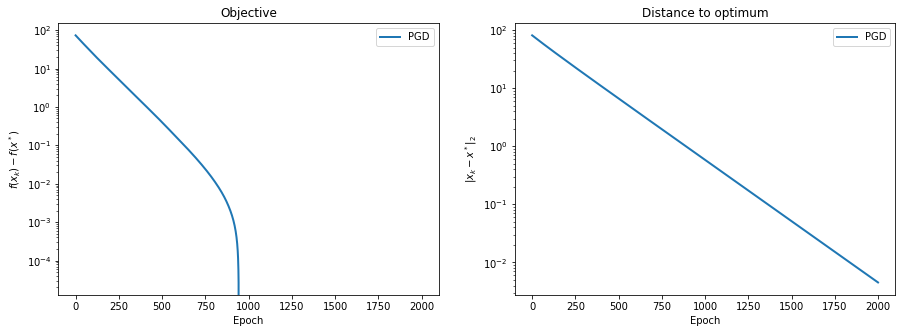

In [12]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state = 24,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
#lbda = 1.
lbda = 0.01
epsilon = 1.

# TODO
def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def grad_huber_loss(params, X, y, epsilon):
    w = params[1:]
    b = params[0]
    grad_huber_mat = grad_huber(y - np.dot(X, w) - b, epsilon=epsilon)
    grad_w = -np.mean(X * np.reshape(grad_huber_mat,(-1,1)), axis = 0)
    grad_b = -np.mean(grad_huber_mat)
    return np.concatenate(([grad_b], grad_w))

def lip_constant(X):
    svdx = np.linalg.svd(X, full_matrices=True, compute_uv=True)[1]
    L = (2/n_samples)*svdx.max()**2
    return L

def lip_constant_2(X):
    L = (2/n_samples)*(np.sum(X**2))
    return L


lips_cont = lip_constant(X)
step = 1./lips_cont
x_min2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, 10000,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

# END TODO

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min2, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

In [13]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

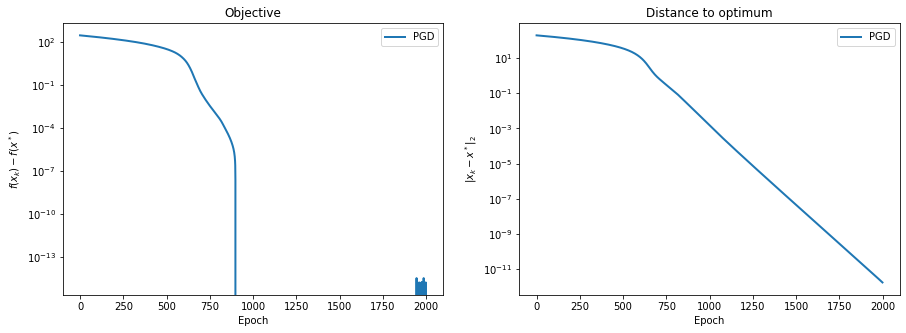

In [14]:
# Run PGD for L1
x_min1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, 10000,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min1, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [15]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        grad_y = grad(y, grad_args[0], grad_args[1], grad_args[2])
        x_new = prox(y - step * grad_y, step, prox_args[0])
        t_new = (1. + np.sqrt(1. + 4* t**2))/2.
        y = x_new + (t - 1) * (x_new - x) / t_new
        t = t_new
        x = x_new

        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

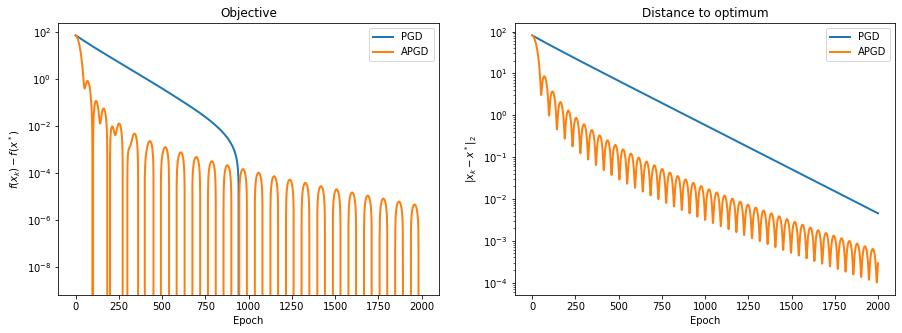

In [16]:
# TODO
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min2, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

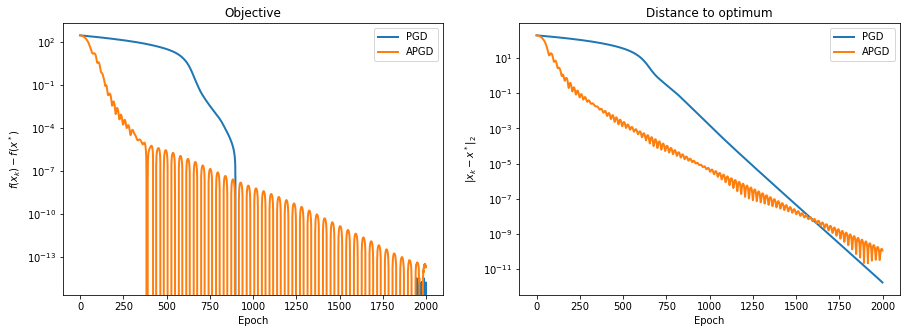

In [17]:
# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min1, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                  grad_args=(X, y, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [18]:
def grad_cd(params, j, X=X, y=y, epsilon=epsilon):
    n_samples = np.shape(X)[0]
    w = params[1:]
    b = params[0]
    if j == 0: 
        return  - np.mean(grad_huber(y - X.dot(w) - b, epsilon = epsilon))
    return - (1. / n_samples) * X[:, j - 1].dot(grad_huber(y - X.dot(w) - b, epsilon = epsilon))

In [19]:
# TODO
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):

    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x[0] =  x[0] - step[0] * grad(x, 0, *grad_args)

        for j in range(1, len(x)):
            x[j] = prox(np.array([0, x[j] - step[j] * grad(x, j, *grad_args)]), step[j], *prox_args)[1]
            
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list
# END TODO

We need to compute the Lipschitz constants for each direction for the Proximate Coordinate Descent, we consider the formula of the loss and derivate along every $w_j$ and $b$. We obtain the following formula:

In [20]:
def step_const_pcd(X):
    n_samples = np.shape(X)[0]
    return 0.5/( np.append(1, np.diag(np.dot(X.T, X))/n_samples))

stepsv = step_const_pcd(X)

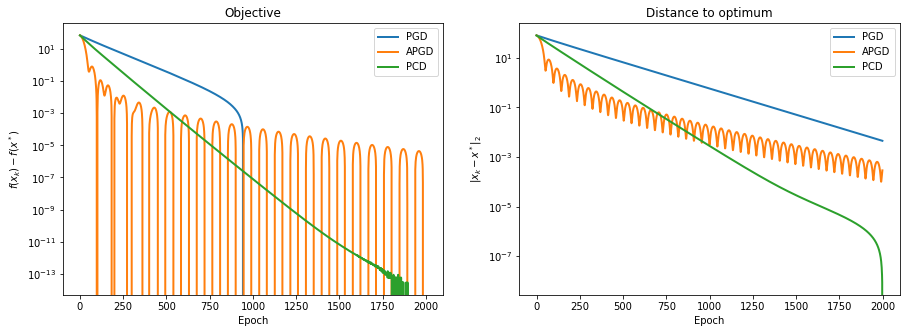

In [23]:
x_min, _ = pcd(x_init, grad_cd, prox_l2, stepsv, 2000, 1, (X, y, epsilon), (lbda,))
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_cd, prox_l2, stepsv, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

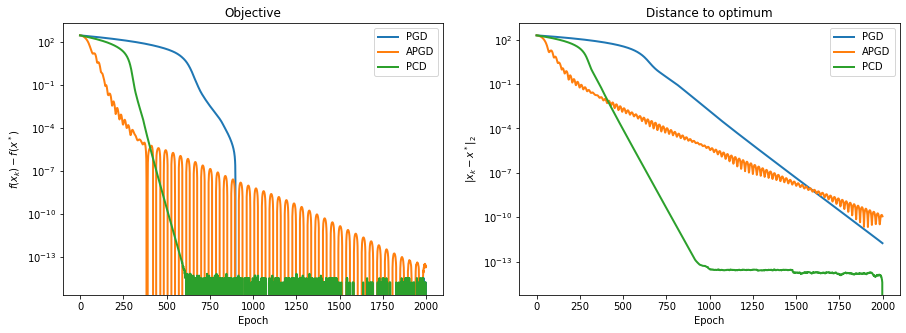

In [23]:
x_min, _ = pcd(x_init, grad_cd, prox_l1, stepsv, 2000, 1, (X, y, epsilon), (lbda,))
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_cd, prox_l1, stepsv, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

We will start by changing the number of samples and see its effect on convergence.

n_samples: 100
n_features: 20


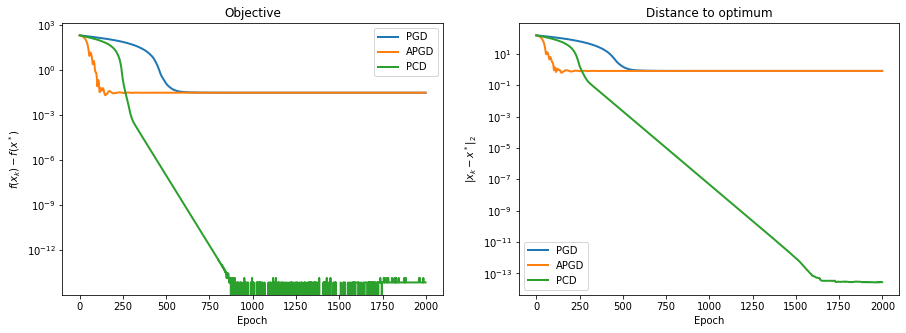

n_samples: 100
n_features: 50


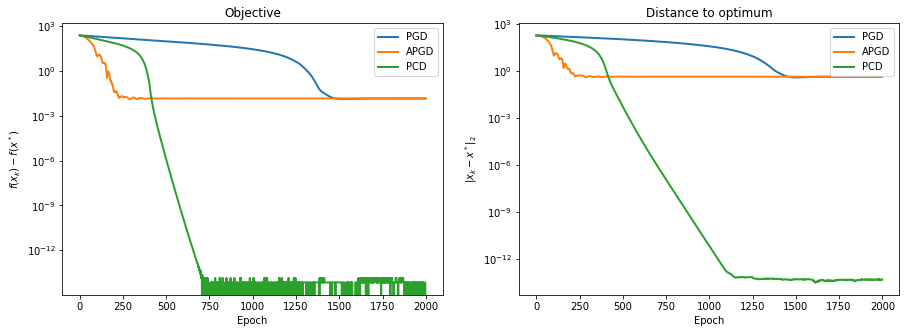

n_samples: 200
n_features: 20


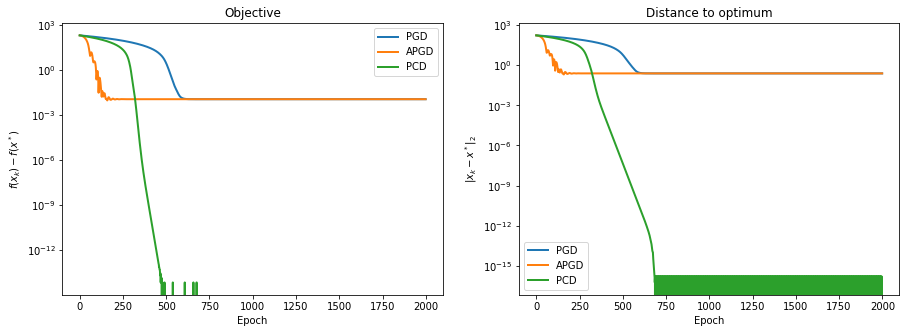

n_samples: 200
n_features: 50


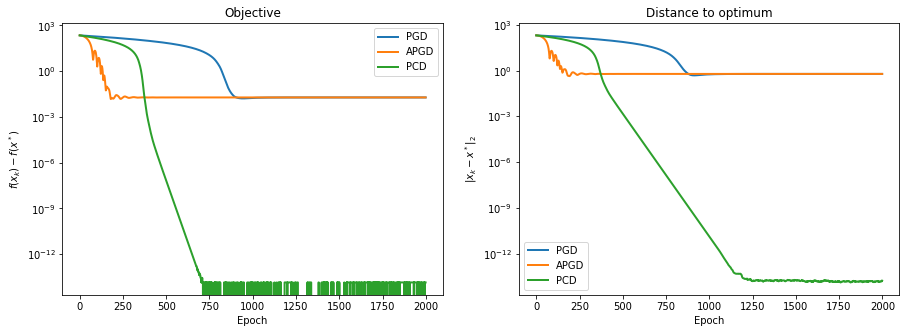

In [34]:
for _n_samples in  [100,200]:
    for _n_features in [20, 50]:
        print("=================================")
        print("n_samples:",_n_samples)
        print("n_features:",_n_features)
        X, y = make_regression(n_samples=_n_samples, n_features=_n_features, random_state = 24,
                               noise=4.0, bias=10.0)
        n_samples, n_features = X.shape

        # Set initial values of parameters to optimize
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        n_iter = 2000
        lbda = 0.1
        epsilon = 1.
        L= lip_constant(X)
        step = 1/L
        step_vector = 0.5/( np.append(1, np.diag(np.dot(X.T, X))/n_samples) )
        
        x_min, _ = pcd(x_init, grad_cd, prox_l1, step_vector, 10000, 1, (X, y, epsilon), (lbda,))

        monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
        monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

        monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
        monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

        monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
        monitor_pcd_l1.run(x_init, grad_cd, prox_l1, step_vector, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

        monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
        solvers = ["PGD", "APGD", "PCD"]
        plot_epochs(monitors, solvers)
        plt.show()
        

We suggest in this case using PCD with a l1 regularisator.

# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [35]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [36]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

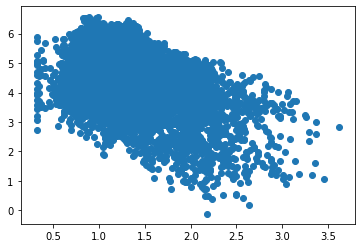

In [37]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        if self.solver == 'pcd':
            self.step = step_const_pcd(X)
        else:
            self.step = 1./lip_constant(X)
        x = np.zeros(n_features+1)
        
        if self.solver=='pgd':
            if self.penalty=='l2':
                x,_ = pgd(x, grad_huber_loss, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = pgd(x, grad_huber_loss, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
        if self.solver=='apgd':
            if self.penalty=='l2':
                x,_ = apgd(x, grad_huber_loss, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                           grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = apgd(x, grad_huber_loss, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                           grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
        if self.solver=='pcd':
            if self.penalty=='l2':
                x,_ = pcd(x, grad_cd, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = pcd(x, grad_cd, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))

        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))

X, y = make_regression(n_samples=500, n_features=100, random_state = 10,
                       noise=4.0, bias=10.0)

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=0.001, penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=0.001, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 41.86425
Solver with L2: apgd   	-   MAE : 2.78580
Solver with L2: pcd   	-   MAE : 2.78499
Solver with L1: pgd   	-   MAE : 34.88609
Solver with L1: apgd   	-   MAE : 2.67850
Solver with L1: pcd   	-   MAE : 2.67846


<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [41]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO
import timeit

ridge_reg = Ridge(alpha=0.001)
print("cross_val_score for Ridge:")
start = timeit.default_timer()
print(cross_val_score(ridge_reg, X, y, scoring='neg_mean_absolute_error'))
print("Running time:",timeit.default_timer()-start,"(s)")

lasso_reg = Lasso(alpha=0.001)
print("cross_val_score for Lasso:")
start = timeit.default_timer()
print(cross_val_score(lasso_reg, X, y, scoring='neg_mean_absolute_error'))
print("Running time:",timeit.default_timer()-start,"(s)")

huber_clf = HuberRegressor(lbda=0.001, penalty='l1', max_iter=1000, solver='apgd')
print("cross_val_score for Huber:")
start = timeit.default_timer()
print(cross_val_score(clf, X, y, scoring='neg_mean_absolute_error'))
print("Running time:",timeit.default_timer()-start,"(s)")
# END TODO

cross_val_score for Ridge:
[-4.20005185 -3.87292396 -3.57210775]
Running time: 0.01311379999970086 (s)
cross_val_score for Lasso:
[-4.19168233 -3.86156151 -3.5663698 ]
Running time: 0.046129800000016985 (s)
cross_val_score for Huber:


C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[-4.1869143  -4.12732381 -3.49871898]
Running time: 31.017035600000327 (s)
